In [1]:
import seaborn as sns
import sys

In [2]:
sns.set_style('dark')
sns.set_context('paper')
sns.set_palette('flare')

In [3]:
!{sys.executable} -m pip install wget
import wget

In [4]:
import os

In [5]:
# Create a dictionary with filenames
filepath= {
    'H1': {
        '32': '../resources/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5',
        '4096': '../resources/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
    },
    'L1': {
        '32': '../resources/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5',
        '4096': '../resources/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
    }
}

In [ ]:
# Download 4096 second data files around GW150914
if not os.path.exists(filepath['H1']['4096']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5
if not os.path.exists(filepath['L1']['4096']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5

In [7]:
# Download 32 second data files around GW150914
if not os.path.exists(filepath['H1']['32']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5
if not os.path.exists(filepath['L1']['32']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5

In [8]:
import h5py

In [9]:
def read_data(filename: str) -> tuple:
    """ Extracts sampling information and the signal samples from the HDF5 file obtained
        using LIGO's sensors to detect the gravitational wave.
        @param filename Filename or filepath to read the HDF5 file
        @return (ts, sample)
    """
    # Open the HDF5 file and extract the strain dataset
    file = h5py.File(filename, 'r')
    strain_dataset = file['strain/Strain']
    
    # Read the sampling time
    ts = strain_dataset.attrs['Xspacing']
    
    # Read the samples
    samples = strain_dataset[:]
    
    return ts, samples

In [79]:
# Read H1 data (both 32 and 4096 seconds of duration)
h1_32_ts, h1_32_samples = read_data(filepath['H1']['32'])
h1_4096_ts, h1_4096_samples = read_data(filepath['H1']['4096'])

In [80]:
# Read L1 data (both 32 and 4096 seconds of duration)
l1_32_ts, l1_32_samples = read_data(filepath['L1']['32'])
l1_4096_ts, l1_4096_samples = read_data(filepath['L1']['4096'])

In [81]:
import matplotlib.pyplot as plt

In [82]:
import numpy as np

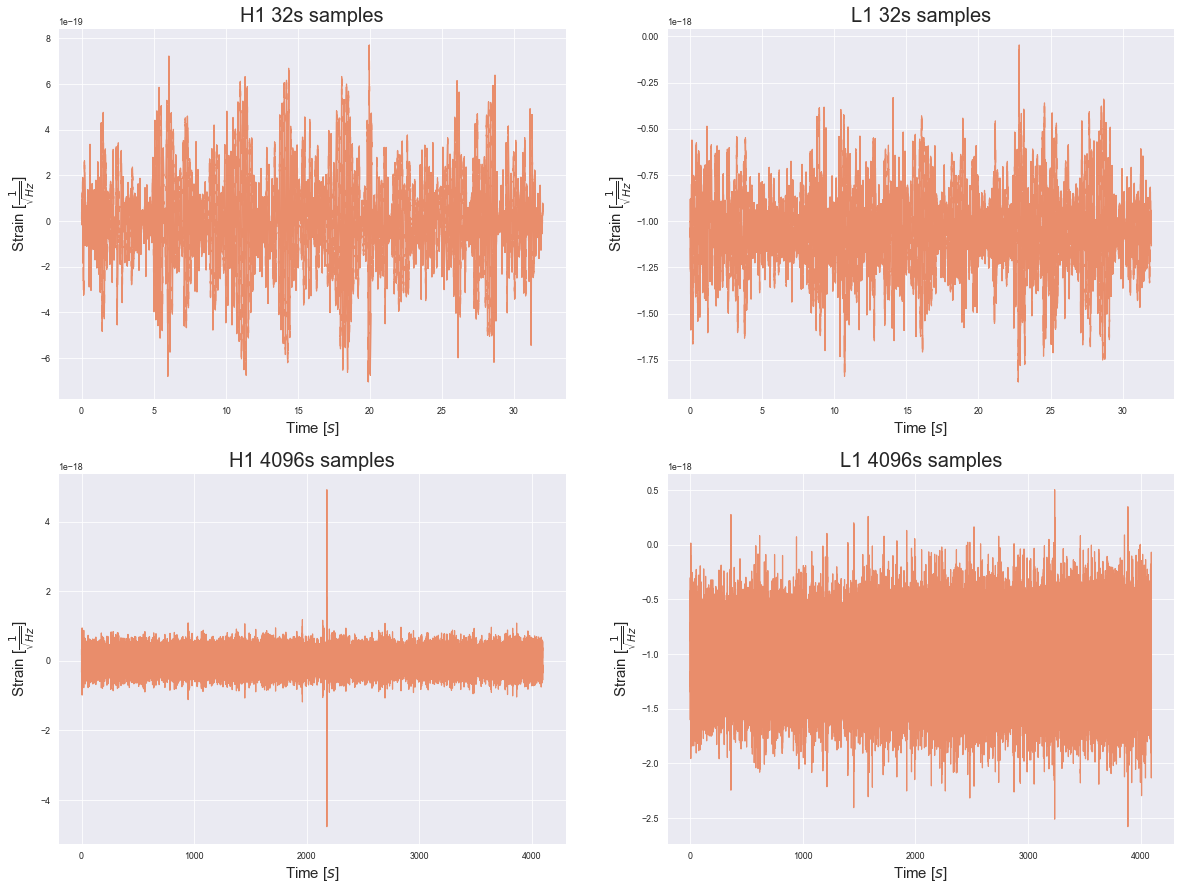

In [83]:
# Create four plotting areas to show L1 and H1 in both durations (32 and 4096 seconds)
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# Plot data
ax[0, 0].plot(np.arange(0, len(h1_32_samples) * h1_32_ts, h1_32_ts), h1_32_samples)
ax[0, 0].set_title('H1 32s samples', fontsize=20)
ax[0, 0].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[0, 0].set_xlabel('Time [$s$]', fontsize=15)
ax[0, 0].grid()

ax[1, 0].plot(np.arange(0, len(h1_4096_samples) * h1_4096_ts, h1_4096_ts), h1_4096_samples)
ax[1, 0].set_title('H1 4096s samples', fontsize=20)
ax[1, 0].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[1, 0].set_xlabel('Time [$s$]', fontsize=15)
ax[1, 0].grid()

ax[0, 1].plot(np.arange(0, len(l1_32_samples) * l1_32_ts, l1_32_ts), l1_32_samples)
ax[0, 1].set_title('L1 32s samples', fontsize=20)
ax[0, 1].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[0, 1].set_xlabel('Time [$s$]', fontsize=15)
ax[0, 1].grid()

ax[1, 1].plot(np.arange(0, len(l1_4096_samples) * l1_4096_ts, l1_4096_ts), l1_4096_samples)
ax[1, 1].set_title('L1 4096s samples', fontsize=20)
ax[1, 1].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[1, 1].set_xlabel('Time [$s$]', fontsize=15)
ax[1, 1].grid()

# Show
plt.show()

In [57]:
from scipy import signal

In [168]:
freqs, psd_periodogram = signal.welch(h1_4096_samples, 1/h1_4096_ts, window='hanning', nfft = 4096)

Text(0.5, 1.0, 'Advanced LIGO strain data near GW150914')

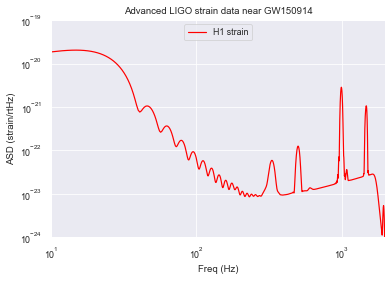

In [169]:
# plot the ASDs:
fmin = 10
fmax = 2000
plt.figure()
plt.loglog(freqs, np.sqrt(psd_periodogram),'r',label='H1 strain')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')

In [170]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [171]:
# We will use interpolations of the ASDs computed above for whitening:
psd_H1_interp = interp1d(freqs, psd_periodogram)
h1_4096_whitened = whitening(h1_4096_samples, psd_H1_interp, h1_4096_ts)

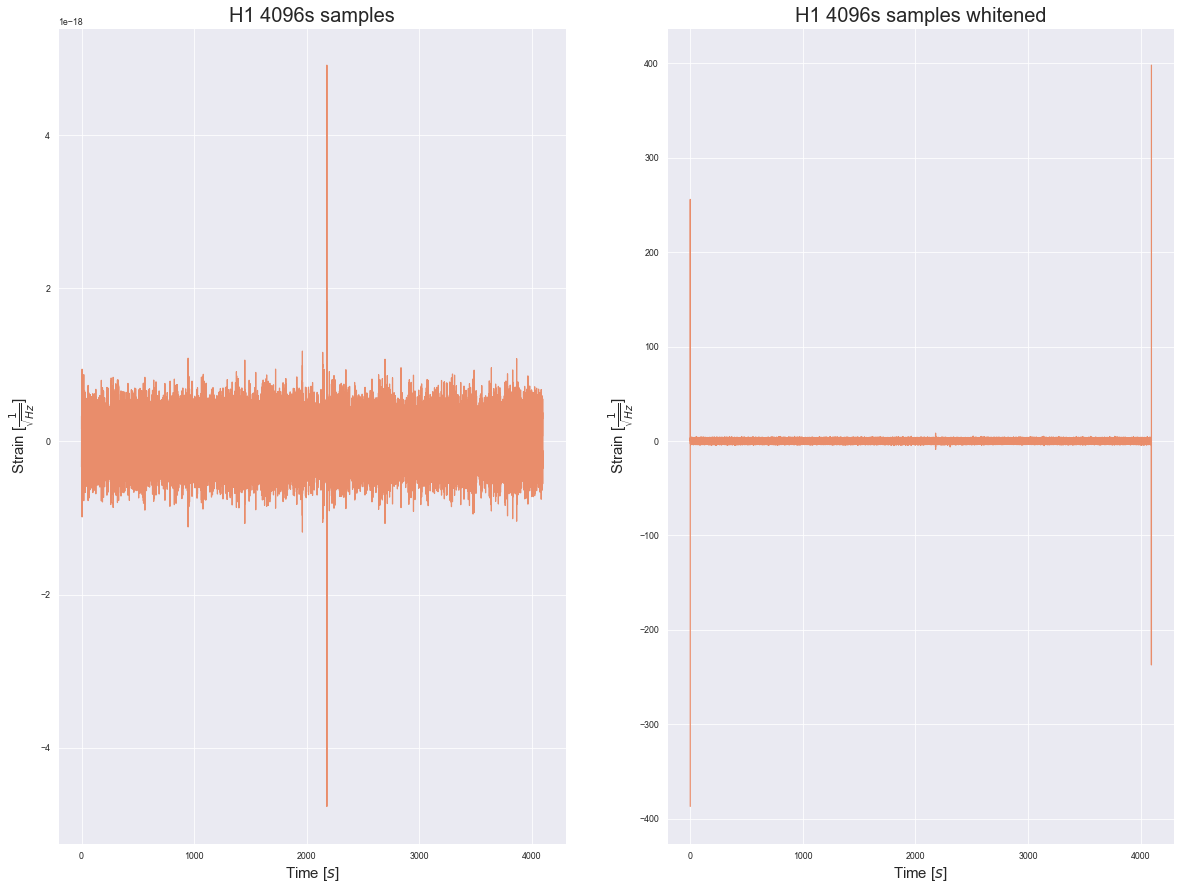

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

ax[0].plot(np.arange(0, len(h1_4096_samples) * h1_4096_ts, h1_4096_ts), h1_4096_samples)
ax[0].set_title('H1 4096s samples', fontsize=20)
ax[0].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[0].set_xlabel('Time [$s$]', fontsize=15)
ax[0].grid()

ax[1].plot(np.arange(0, len(h1_4096_whitened) * h1_4096_ts, h1_4096_ts), h1_4096_whitened)
ax[1].set_title('H1 4096s samples whitened', fontsize=20)
ax[1].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[1].set_xlabel('Time [$s$]', fontsize=15)
ax[1].grid()